# 1. Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import dalex as dx


from sklearn.model_selection import train_test_split, StratifiedKFold
import shap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from alibi.explainers import Counterfactual
from sklearn.inspection import PartialDependenceDisplay


sns.set_theme(style="whitegrid")

c:\Users\crost\Documents\GitHub\Datathon-2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Dataset

In [2]:
# Load training dataset
df_train = pd.read_csv('./dataset.csv')
X_train_full = df_train.iloc[:,1:].drop('target_variable', axis=1)

y_train_full = df_train['target_variable']

In [3]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

# 3. Model

## XGBoost

In [4]:
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

# fit model
bst.fit(X_train, y_train)

# make predictions
preds = bst.predict(X_test)

### Confusion matrix

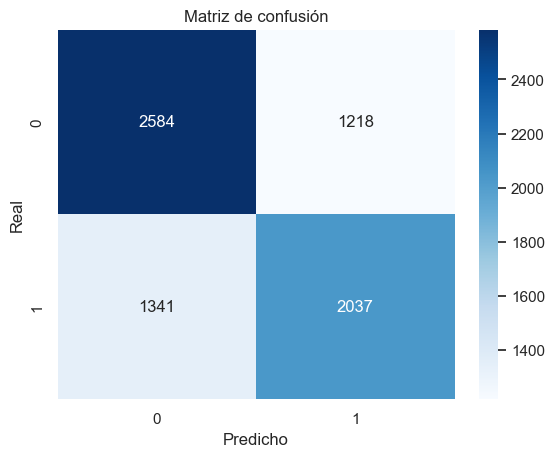

In [5]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [6]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3802
           1       0.63      0.60      0.61      3378

    accuracy                           0.64      7180
   macro avg       0.64      0.64      0.64      7180
weighted avg       0.64      0.64      0.64      7180



### Buscando los mejores parámetros

In [7]:
# Definir el modelo base
bst = XGBClassifier(objective='binary:logistic')

# Espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Búsqueda aleatoria (más rápida que GridSearch)
search = RandomizedSearchCV(
    estimator=bst,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinaciones a probar
    scoring='f1',  # Optimizar F1-score
    cv=StratifiedKFold(n_splits=5),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenar
search.fit(X_train, y_train)

# Mejor modelo
best_bst = search.best_estimator_
print("Mejores parámetros:", search.best_params_)


# Mejores parámetros: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [8]:
# create model instance
best_bst = XGBClassifier(subsample=0.9, n_estimators=300, min_child_weight=1, max_depth=9, learning_rate=0.1, colsample_bytree=0.9, objective='binary:logistic')

# fit model
best_bst.fit(X_train, y_train)

# make predictions
preds = best_bst.predict(X_test)

### Confusion matrix

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3802
           1       0.82      0.82      0.82      3378

    accuracy                           0.83      7180
   macro avg       0.83      0.83      0.83      7180
weighted avg       0.83      0.83      0.83      7180



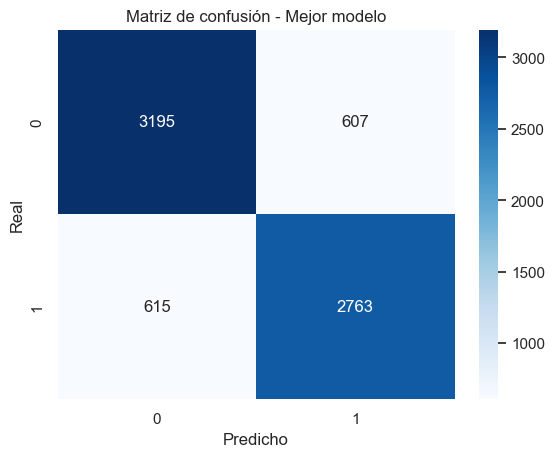

In [9]:
# Predecir con el mejor modelo
preds_best = best_bst.predict(X_test)

# Calcular métricas
print(classification_report(y_test, preds_best))

# Matriz de confusión
cm_best = confusion_matrix(y_test, preds_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - Mejor modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

### Métodos locales

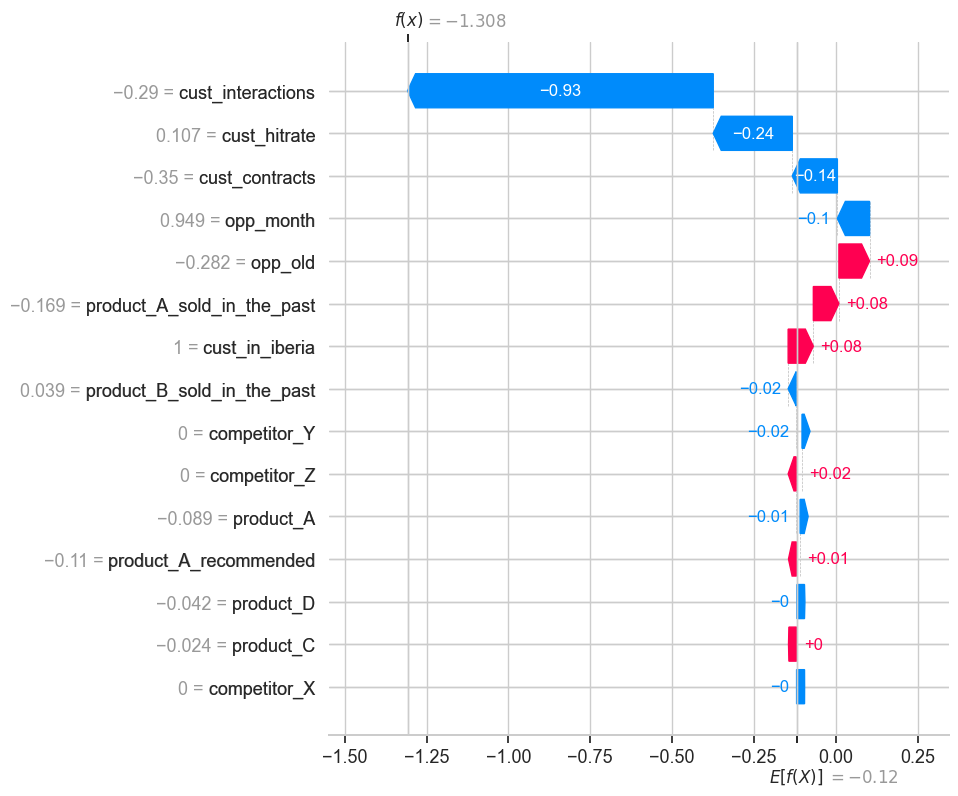

In [10]:
explainer = shap.TreeExplainer(best_bst)

explanation = explainer(X_test.iloc[:1])  
shap.waterfall_plot(explanation[0], max_display=len(X_test.columns))

#### Sharp

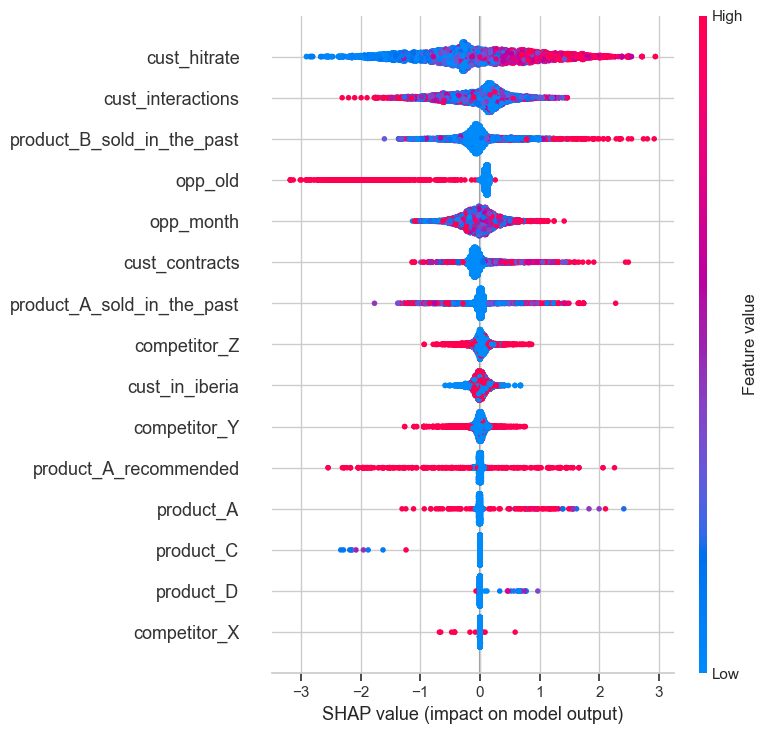

In [11]:
# Crear el explainer SHAP para XGBoost
explainer = shap.TreeExplainer(best_bst)

# Obtener SHAP values
shap_values = explainer.shap_values(X_test)

feature_names = X_test.columns.tolist()


# Si es clasificación binaria, XGBoost devuelve una lista de arrays
# shap_values[0] = clase 0, shap_values[1] = clase 1
# Usamos la clase positiva (1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Tomamos la clase 1 (ganado)

# Summary Plot: Muestra la importancia y la dirección de las variables
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

#### Lime

In [12]:
# Crear el explainer LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,                   # Datos de entrenamiento (para generar muestras)
    feature_names=feature_names,      # Nombres de las columnas
    class_names=['Lost', 'Won'],      # Etiquetas de clase (0 = Lost, 1 = Won)
    mode='classification'             # Tipo de problema
)

# Elegir una instancia específica para explicar (ej. índice 0)
i = 0
exp = explainer_lime.explain_instance(
    X_test.iloc[i].values,            # Instancia a explicar
    best_bst.predict_proba,           # Función de predicción del modelo (probabilidades)
    num_features=X_test.shape[1]
)

# Mostrar la explicación
exp.save_to_file('lime_explanation_xgboost.html')  # Guardar como HTML

#### Ice

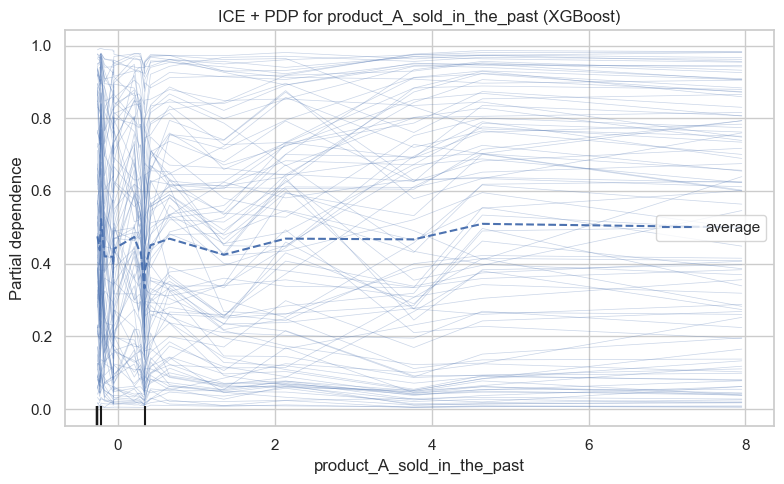

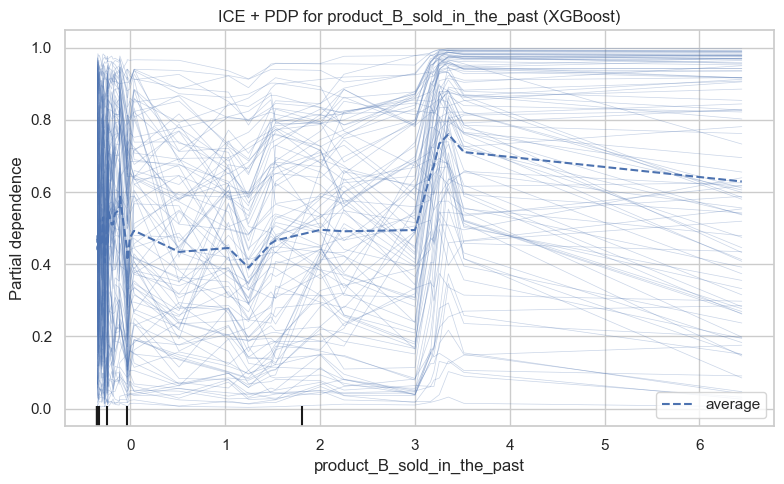

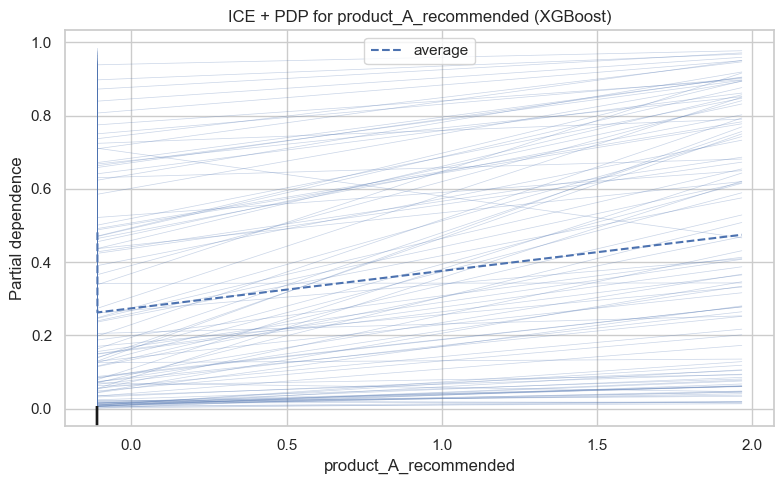

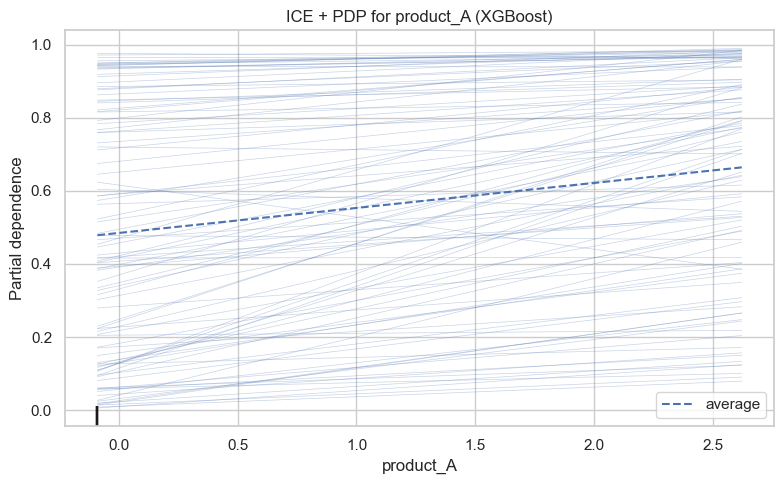

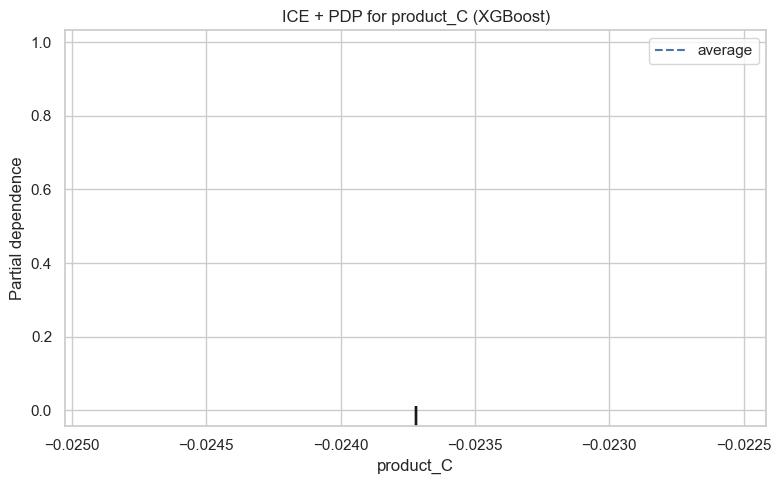

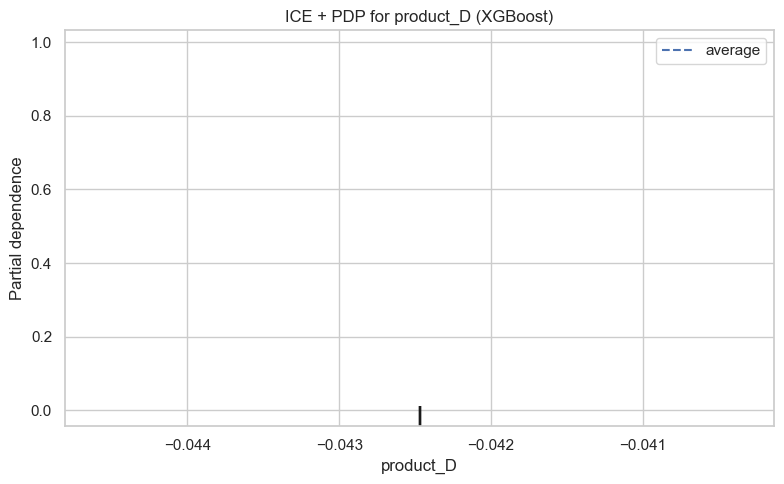

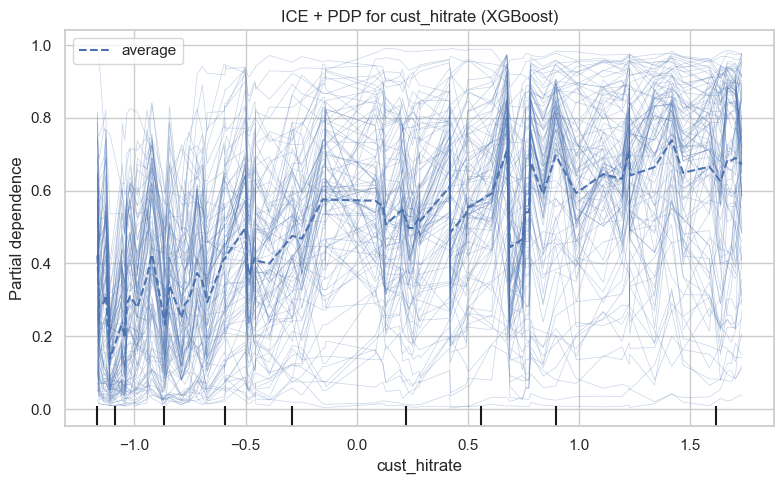

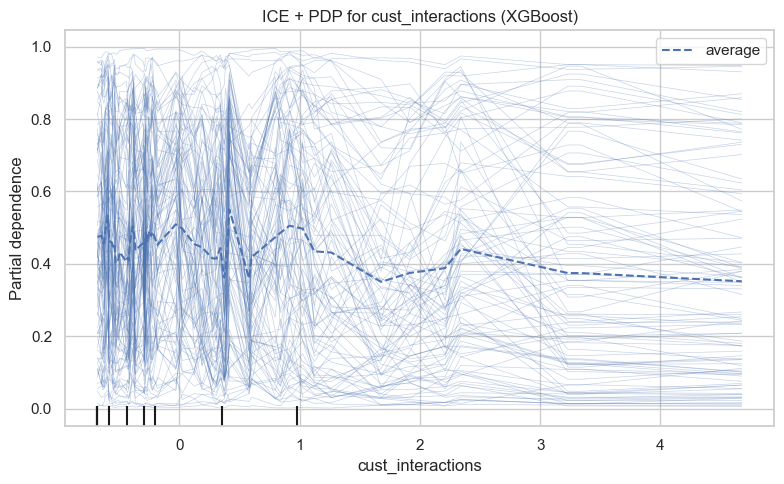

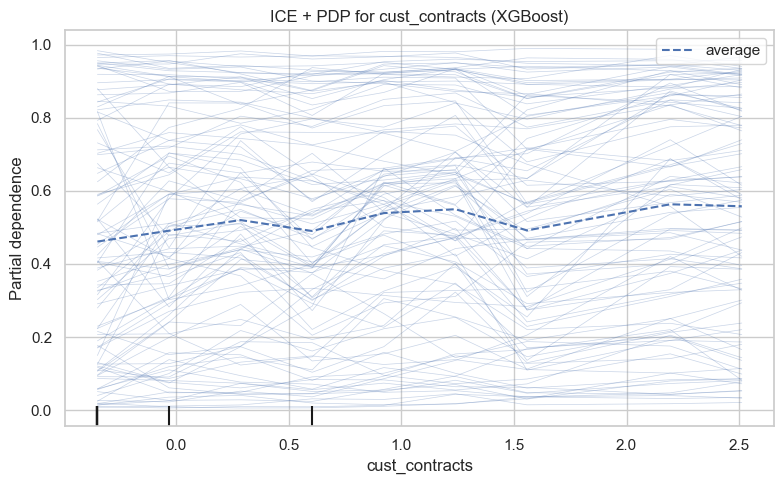

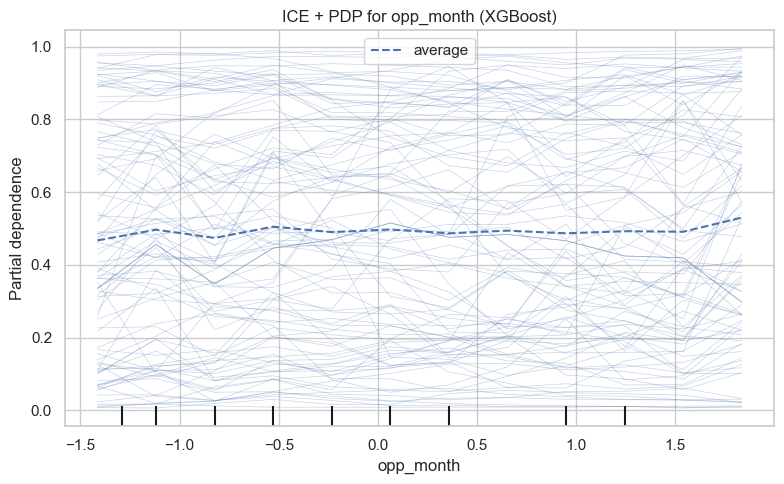

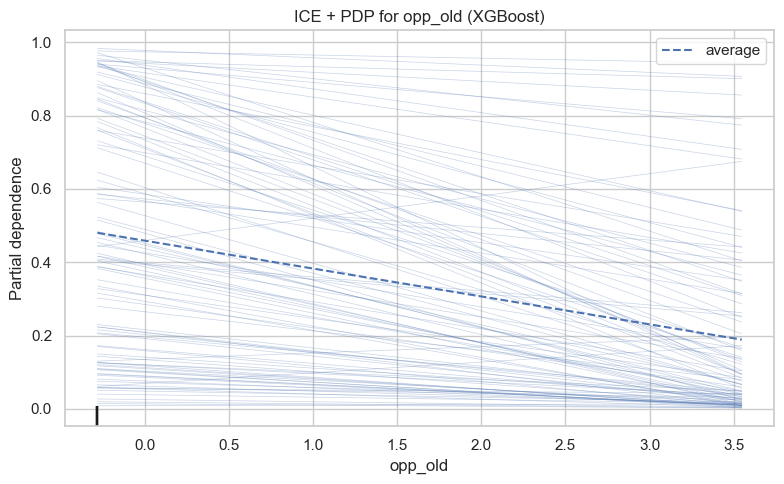

In [13]:
# Lista de variables continuas verdaderas
continuous_features = [
    'product_A_sold_in_the_past',
    'product_B_sold_in_the_past',
    'product_A_recommended',
    'product_A',
    'product_C',
    'product_D',
    'cust_hitrate',
    'cust_interactions', 
    'cust_contracts',  
    'opp_month', 
    'opp_old'
]

# Muestrear 100 observaciones para claridad
X_sample = X_test.sample(100, random_state=42)

# Generar ICE + PDP para cada variable
for feature in continuous_features:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    PartialDependenceDisplay.from_estimator(
        best_bst,
        X_sample,
        features=[feature],
        kind='both',      # PDP + ICE
        ax=ax
    )
    
    ax.set_title(f"ICE + PDP for {feature} (XGBoost)")
    ax.set_ylabel("Predicted Probability (Won)")
    plt.tight_layout()
    plt.show()

#### Ceteris Paribus Plot

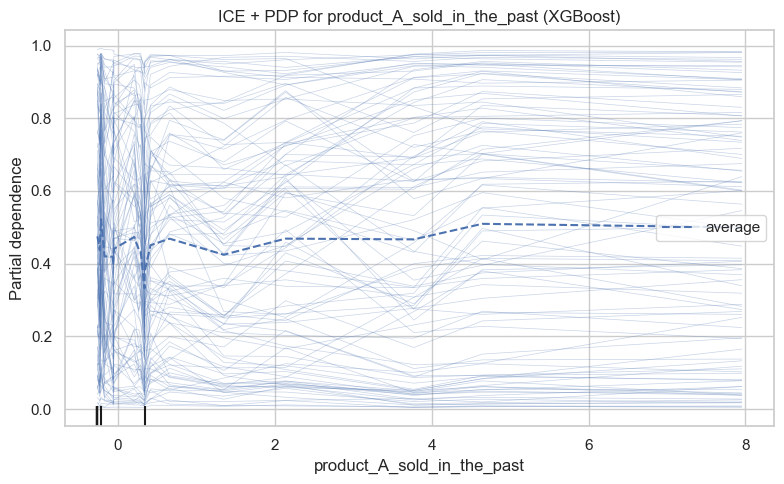

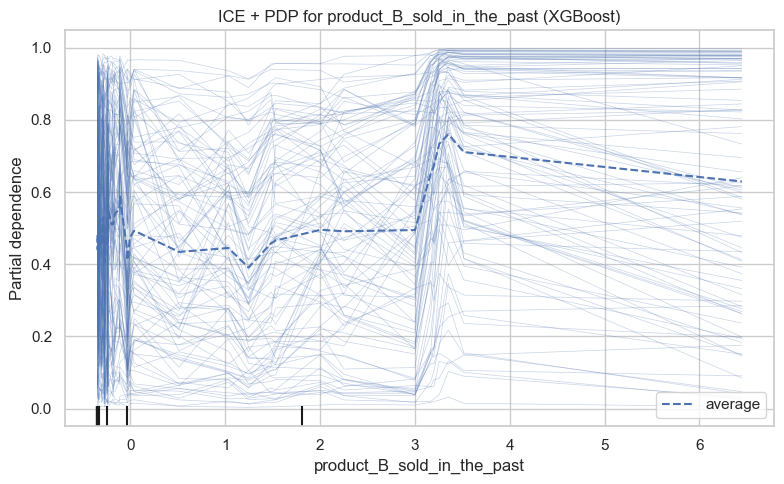

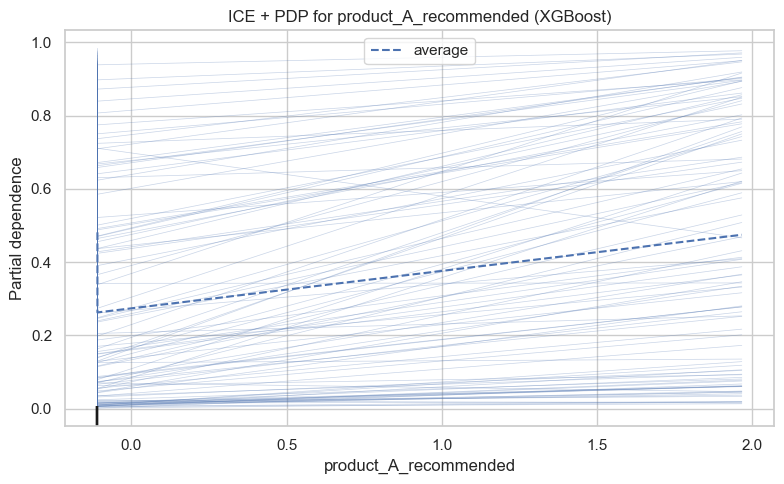

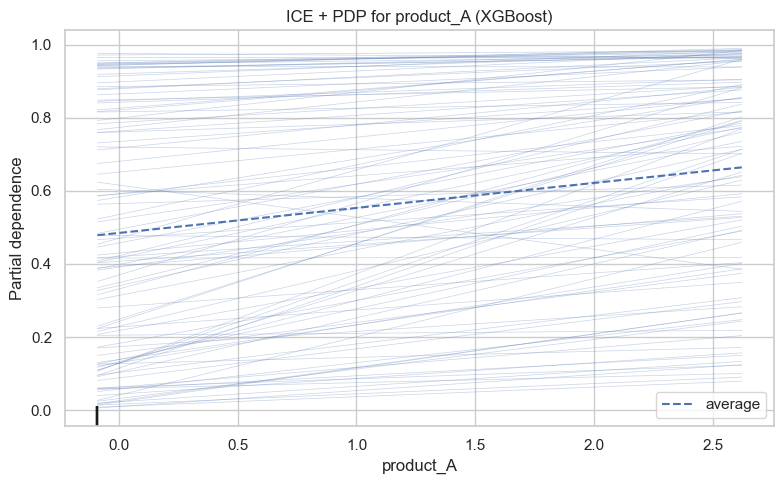

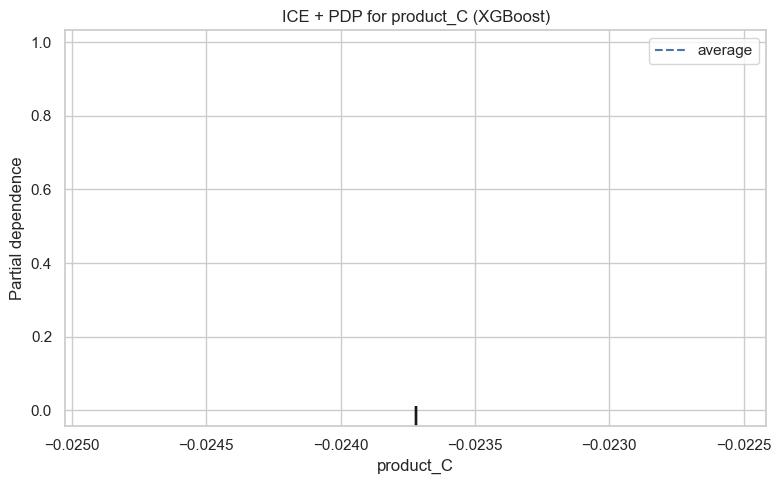

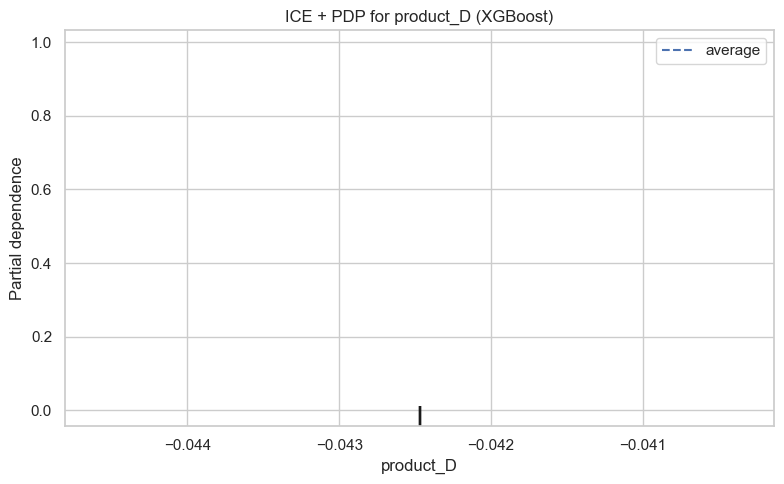

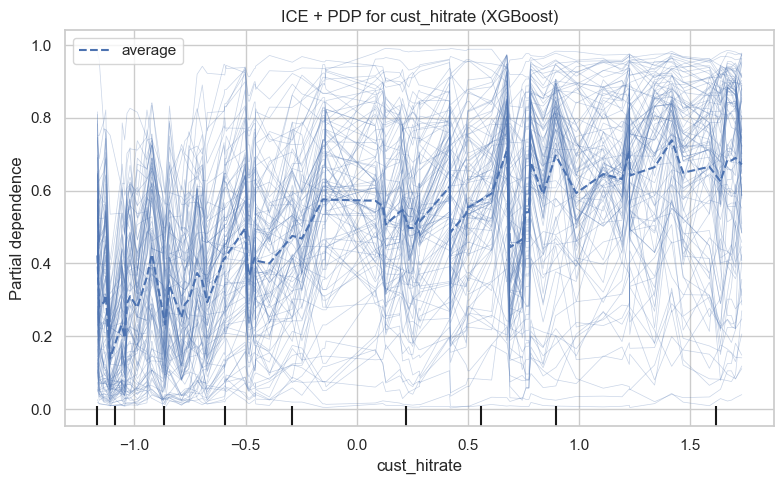

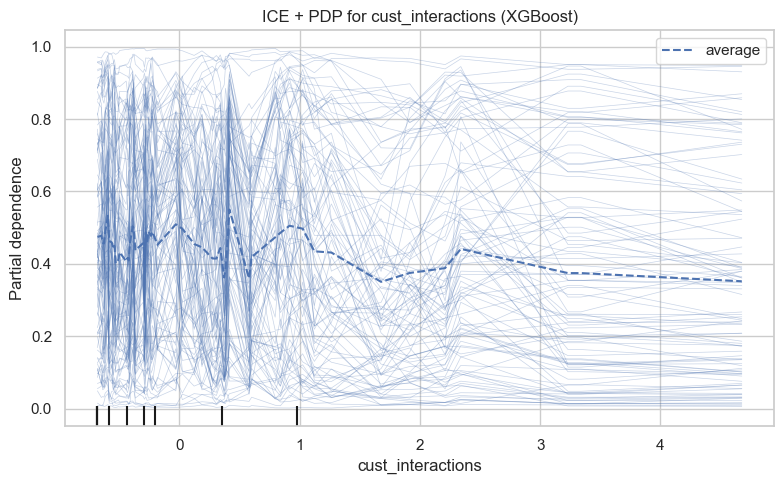

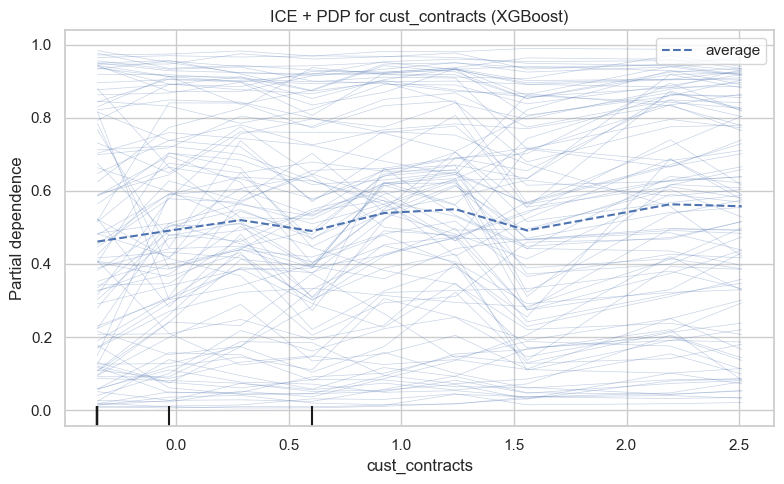

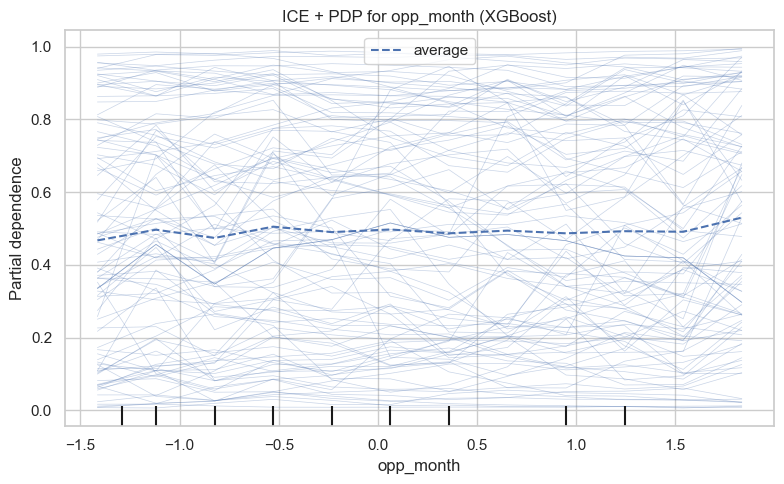

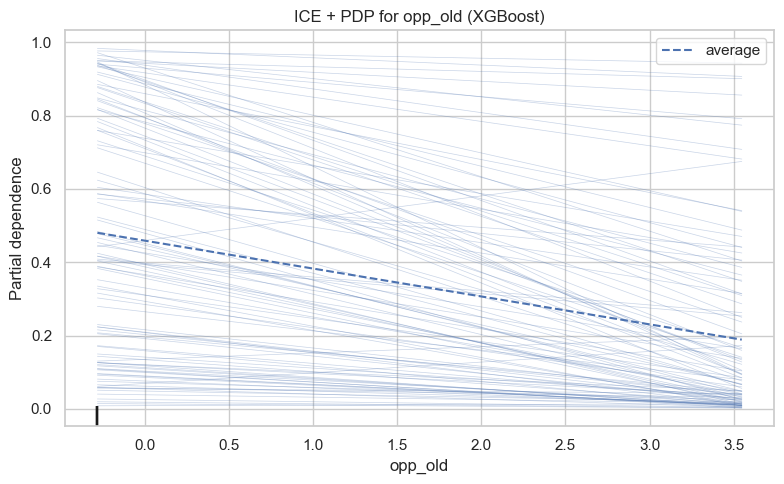

In [14]:
# Lista de variables continuas verdaderas
continuous_features = [
    'product_A_sold_in_the_past',
    'product_B_sold_in_the_past',
    'product_A_recommended',
    'product_A',
    'product_C',
    'product_D',
    'cust_hitrate',
    'cust_interactions', 
    'cust_contracts',  
    'opp_month', 
    'opp_old'
]

# Muestrear 100 observaciones para claridad
X_sample = X_test.sample(100, random_state=42)

# Generar ICE + PDP para cada variable
for feature in continuous_features:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    PartialDependenceDisplay.from_estimator(
        best_bst,
        X_sample,
        features=[feature],
        kind='both',      # PDP + ICE
        ax=ax
    )
    
    ax.set_title(f"ICE + PDP for {feature} (XGBoost)")
    ax.set_ylabel("Predicted Probability (Won)")
    plt.tight_layout()
    plt.show()

#### CounterFactual Explanations

### Métodos globales

In [17]:
# Calcular el valor absoluto medio por característica
mean_abs_shap = np.abs(shap_values).mean(axis=0)  # Promedio sobre todas las instancias

# Crear DataFrame para facilitar la visualización
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature_{i}" for i in range(X_test.shape[1])]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['feature'], importance_df['mean_abs_shap'], color='lightcoral')

# Añadir valores numéricos en las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

plt.xlabel('mean(|SHAP|)')
plt.title('Feature Importance - Mean Absolute SHAP Values')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Permutation Feature Importance

In [ ]:
# Calcular importancia
perm_imp = permutation_importance(
    best_bst, 
    X_test, 
    y_test, 
    n_repeats=5, 
    random_state=42,
    scoring='f1'  # Usa la métrica del reto
)

# Crear DataFrame
perm_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values('importance', ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(perm_imp_df['feature'], perm_imp_df['importance'])
plt.xlabel('Permutation Importance (Δ F1-score)')
plt.title('Global Feature Importance via Permutation')
plt.gca().invert_yaxis()
plt.show()

#### Ale

In [ ]:
# Definir función de predicción que acepte modelo y datos
def predict_fn(model, X):
    return model.predict_proba(X)[:, 1]

# Crear el explainer
explainer = dx.Explainer(
    model=best_bst,
    data=X_test,
    predict_function=predict_fn  # función que acepta (model, X)
)

# ALE plot
ale_obj = explainer.model_profile(type='accumulated', variables=['cust_interactions'])
ale_obj.plot()

In [ ]:
ale_obj = explainer.model_profile(
    type='accumulated',
    variables=['cust_interactions', 'opp_old', 'product_A_sold_in_the_past']
)
ale_obj.plot()